In [29]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel
from src import config
from src.plots import PlotGenerator

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [31]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [32]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the dataset: (110527, 21)
Final columns in the dataset: Index(['Gender

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Clustering Analysis
This section covers unsupervised clustering using PCA, KMeans, and Gaussian Mixture Models (GMM). We will visualize clusters, tune hyperparameters, and evaluate using Silhouette and Davies-Bouldin scores.

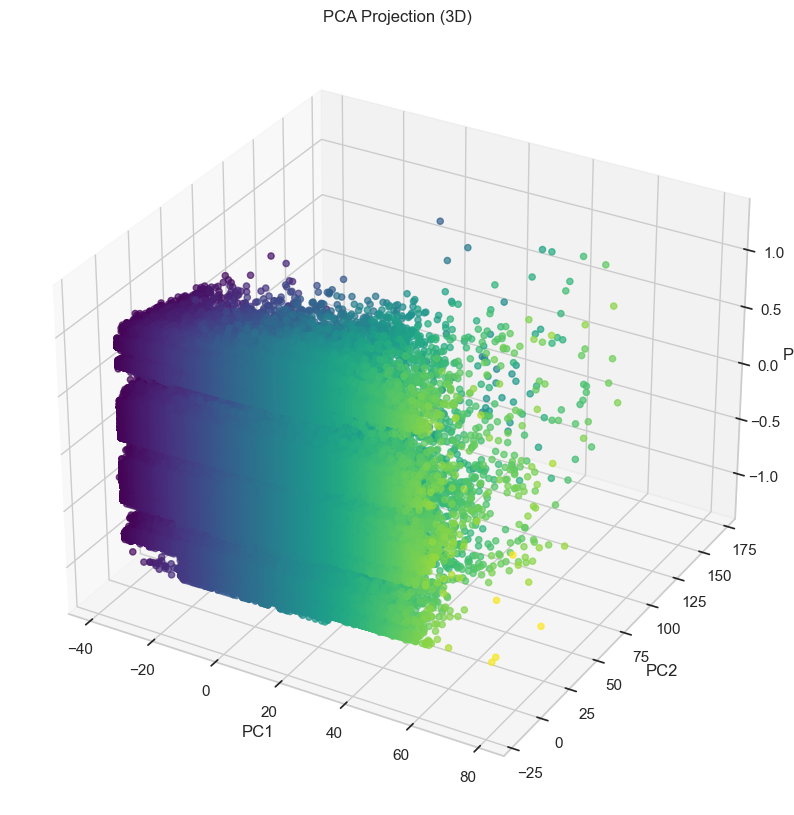

In [40]:
# Visualize data using PCA (if not already done)
from sklearn.decomposition import PCA

if is_step_enabled('unsupervised_pca'):
    pca = PCA(n_components=3, random_state=RANDOM_STATE)
    pca_result = pca.fit_transform(df.select_dtypes(include=[np.number]))
    colors = plt.cm.viridis((pca_result[:, 0] - pca_result[:, 0].min()) / (pca_result[:, 0].ptp()))
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, alpha=0.7)
    ax.set_title('PCA Projection (3D)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()
